In [2]:
import pathlib
import yaml 
import numpy as np
import sys
import random
import matplotlib.pyplot as plt


# sys.path.remove('/root/repos/polarseg-kitti')
# sys.path.append('~/polarseg-kitti')
# import src.misc.utils as utils

print(sys.path)

if '~/polarseg-kitti' not in sys.path:
    sys.path.append('~/polarseg-kitti')

import src.misc.utils as utils
from src.data.dataloader import PolarNetDataModule, SemanticKITTI
from torch.utils.data import DataLoader

['/root/repos/polarseg-kitti/notebooks', '/root/miniconda3/envs/polarseg-kitti/lib/python310.zip', '/root/miniconda3/envs/polarseg-kitti/lib/python3.10', '/root/miniconda3/envs/polarseg-kitti/lib/python3.10/lib-dynload', '', '/root/miniconda3/envs/polarseg-kitti/lib/python3.10/site-packages', '/root/repos/polarseg-kitti']


/root/miniconda3/envs/polarseg-kitti/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# projection = "polara"
# valid_projection_list = ["polar", "cartesian", "spherical"]

# assert projection in valid_projection_list, f"incorrect projection type, here is the list of valid proejctions: {valid_projection_list}"

In [4]:
semkitti = SemanticKITTI("/root/repos/polarseg-kitti/data/debug", data_split='valid')

semkitti_loader = DataLoader(semkitti)

scan = next(iter(semkitti_loader))

xyz = scan[0][0,:,:3].numpy()
xyz = utils.random_flip(xyz.copy())
xyz = utils.random_rot(xyz.copy())



In [33]:
def convert2polar(xyz):
    r = np.sqrt(xyz[:,0]**2+xyz[:,1]**2).reshape(-1,1)
    theta = np.arctan2(xyz[:,1],xyz[:,0]).reshape(-1,1)
    z = xyz[:,2].reshape(-1,1)
    return np.concatenate((r, theta, z), axis=1)

def convert_to_voxels(coordinate, fixed_space = False, polar = False):

    grid_size = np.array([480,360,32])
    min_vol = np.array([-50,-50,-3])
    max_vol = np.array([50,50,1.5])

    if polar:
        coordinate = convert2polar(coordinate)

    # calculate the grid indices
    if fixed_space:
        coordinate_limited = utils.limit(coordinate, min_vol, max_vol)
    else:
            coordinate_limited = coordinate
            max_vol = np.amax(coordinate, axis=0)
            min_vol = np.amin(coordinate, axis=0)
    print(max_vol, min_vol)

    step_size = (max_vol - min_vol) / (grid_size - 1)
    print(step_size)
    grid_index = np.floor((coordinate_limited - min_vol)/ step_size).astype(int)
    voxel_position = np.indices(grid_size)*step_size.reshape([-1,1,1,1])+min_vol.reshape([-1,1,1,1])

    return voxel_position, coordinate


# rtz = convert2polar(xyz.copy())
clipped_polar_voxels, clipped_rtz = convert_to_voxels(xyz, fixed_space=True, polar = True)
polar_voxels, rtz = convert_to_voxels(xyz, fixed_space=False, polar = True)
cart_voxels, clipped_xyz = convert_to_voxels(xyz, fixed_space=False, polar=False)


[50.  50.   1.5] [-50 -50  -3]
[0.20876827 0.27855153 0.14516129]
[80.00205    3.1415615  2.956046 ] [  1.2398765  -3.1415863 -27.63914  ]
[0.16443043 0.0175018  0.98694143]
[79.90394  78.70911   2.956046] [-79.84459 -78.86237 -27.63914]
[0.33350425 0.43891775 0.98694143]


(3, 480, 360, 32)
(123389, 3)


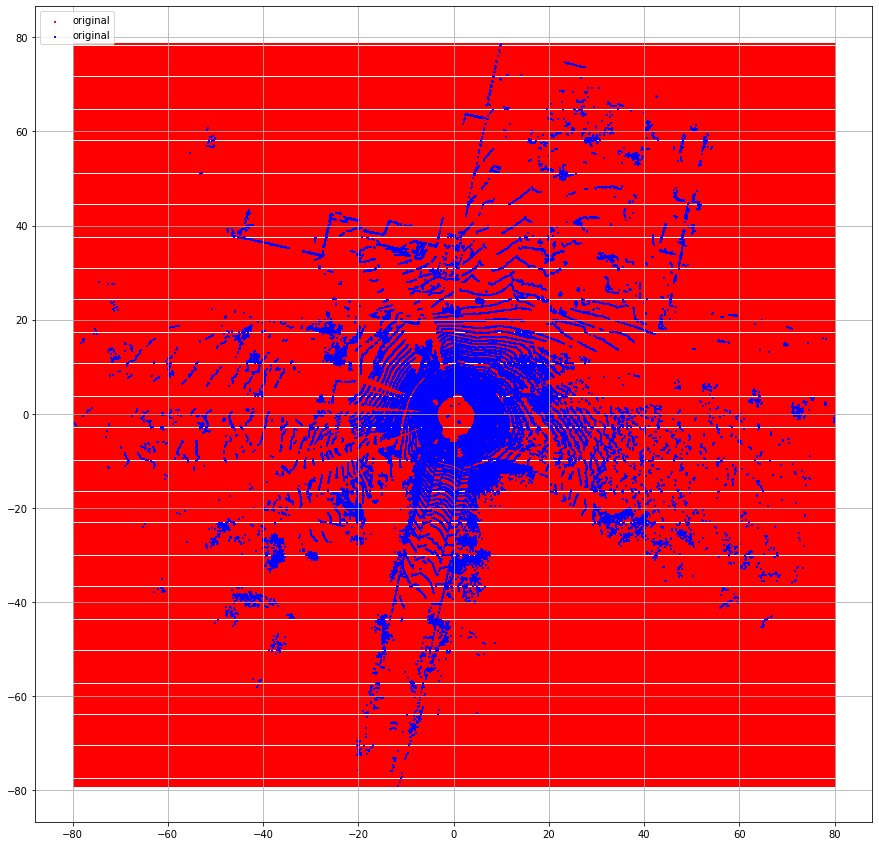

In [42]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(111)

print(cart_voxels.shape)
print(xyz.shape)

ax1.scatter(cart_voxels[0],cart_voxels[1], c='r', marker="s", label='original', s=1)
ax1.scatter(xyz[:,0],xyz[:,1], c='b', marker="s", label='original', s=1)
# ax1.scatter(xyz_flip[:,0],xyz_flip[:,1],c='r', marker="o", label='flipped', s=1)
# ax1.scatter(xyz_rot[:,0],xyz_rot[:,1],c='g', marker="x", label='rotated', s=1)
plt.legend(loc='upper left');
plt.grid()
plt.show()

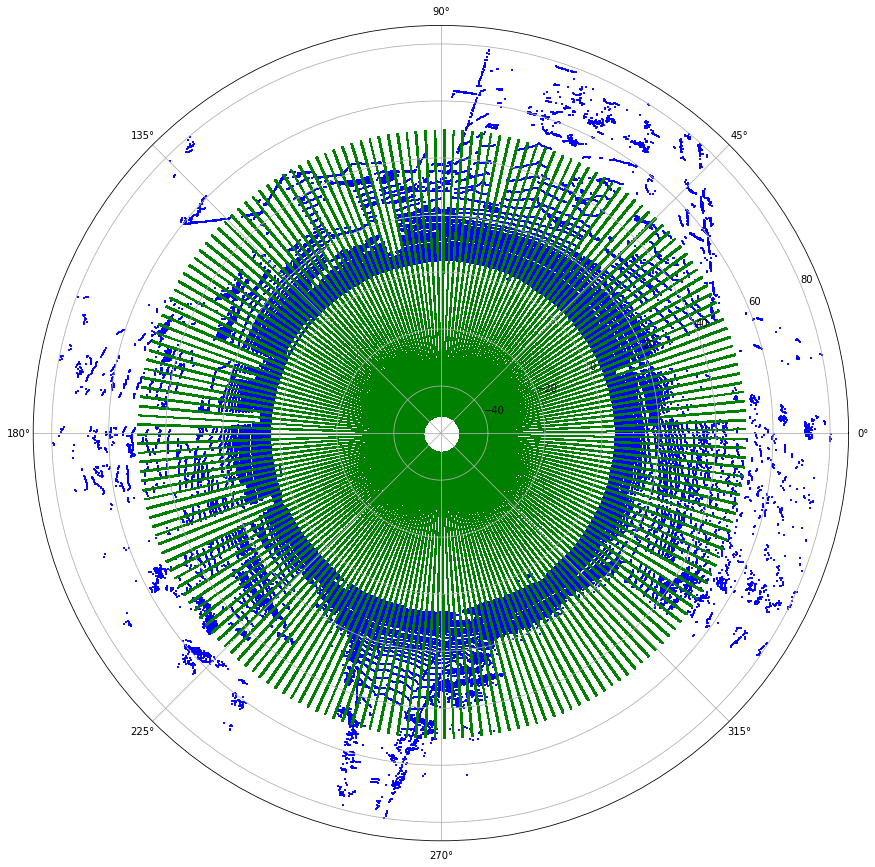

In [47]:
fig = plt.figure(figsize=(15,15))
plt.axes(projection = 'polar', )
plt.scatter(clipped_rtz[:,1], clipped_rtz[:,0], c='b', marker="s", label='original', s=1)
plt.scatter(clipped_polar_voxels[1], clipped_polar_voxels[0], c='g', marker="s", label='original', s=1)

# plt.scatter(rtz[:,1], rtz[:,0], c='b', marker="s", label='original', s=1)
# plt.scatter(polar_voxels[1], polar_voxels[0], c='r', marker="s", label='original', s=1)
# plt.scatter(clipped_rtz[1], clipped_rtz[0], c='r', marker="s", label='original', s=1)
plt.show()

## Label handling experimental

In [ ]:
def load_SemKITTI_yaml(file, label_name=False):
    # FIXME: rewrite or reference

    with open(file, "r") as stream:
        semkitti_dict = yaml.safe_load(stream)

    # data tuple for unique label values and keys
    if label_name:
        unique_dict = dict()
        # TODO: rewrite or cite this
        for i in sorted(list(semkitti_dict["learning_map"].keys()))[::-1]:
            unique_dict[semkitti_dict["learning_map"][i]] = semkitti_dict["labels"][i]

        unique_keys = np.asarray(sorted(list(unique_dict.keys())))[1:] - 1
        unique_labels = [unique_dict[x] for x in unique_keys + 1]

        return (unique_keys, unique_labels)

    return semkitti_dict

def remap_labels(labels, semkitti_dict):
    for i in labels:
        labels[i] = semkitti_dict["labels"][labels[i]]
    return labels

In [ ]:
semkitti_dict = load_SemKITTI_yaml("../semantic-kitti.yaml", True)

semkitti_dict

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 ['car',
  'bicycle',
  'motorcycle',
  'truck',
  'bus',
  'person',
  'bicyclist',
  'motorcyclist',
  'road',
  'parking',
  'sidewalk',
  'other-ground',
  'building',
  'fence',
  'vegetation',
  'trunk',
  'terrain',
  'pole',
  'traffic-sign'])

In [ ]:
with open("../semantic-kitti.yaml", "r") as stream:
    semkitti_dict = yaml.safe_load(stream)

labels = np.fromiter(semkitti_dict["learning_map"].values(), dtype=np.int8)
unique_labels = np.unique(labels)[:-1] # one too much (unlabelled)
unique_names = []
key_list = list(semkitti_dict["learning_map"].keys())

for i in unique_labels:
    unique_names.append(semkitti_dict["labels"][semkitti_dict["learning_map_inv"][i+1]])

unique_names


['car',
 'bicycle',
 'motorcycle',
 'truck',
 'other-vehicle',
 'person',
 'bicyclist',
 'motorcyclist',
 'road',
 'parking',
 'sidewalk',
 'other-ground',
 'building',
 'fence',
 'vegetation',
 'trunk',
 'terrain',
 'pole',
 'traffic-sign']

In [ ]:
semkitti_dict = load_SemKITTI_yaml("../semantic-kitti.yaml", False)

def find_ignore_label(semkitti_dict: dict):
    for key, value in semkitti_dict["learning_ignore"].items():
        if value == True:
            return key

label = find_ignore_label(semkitti_dict=semkitti_dict)
print(label)

0


## Flip augmentation toy example

In [ ]:
choice = random.randint(0,3)

def random_flip(xyz):
    if choice == 0:
        print("No augmentation\n")
    elif choice == 1:
        print("Flip along x-axis\n")
        xyz = -xyz[:,0]
    elif choice == 2:
        print("Flip along y-axis\n")
        xyz = -xyz[:,1]
    elif choice == 3:
        print("Flip along both axis\n")
        xyz_flip1 = -xyz[:,0]
        xyz = -xyz_flip1[:,1]
    return xyz


## Rotation augmentation toy example

In [ ]:
import numpy as np
xyz = np.random.randint(800, 1000, size=[5, 3])
deg = np.random.randint(0,360)
print(xyz)
x = xyz[:,0]*np.cos(np.deg2rad(deg))-xyz[:,1]*np.sin(np.deg2rad(deg))
y = xyz[:,1]*np.cos(np.deg2rad(deg))+xyz[:,0]*np.sin(np.deg2rad(deg))
z = xyz[:,2]

rot_xy = np.concatenate((x.reshape(-1,1),y.reshape(-1,1), z.reshape(-1,1)), axis = 1)
rot_xy

[[973 907 931]
 [980 963 968]
 [813 895 929]
 [806 903 880]
 [995 992 847]]


array([[ 940.75343118,  940.4046904 ,  931.        ],
       [ 945.79479515,  996.61487319,  968.        ],
       [ 781.26969282,  922.828081  ,  929.        ],
       [ 773.99476106,  930.57891114,  880.        ],
       [ 959.77357216, 1026.12069962,  847.        ]])